In [8]:
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.feature_extraction.text import TfidfVectorizer
import time

### Data Cleaning Functions

# Getting rid of unecesarry columns

def remove_columns(df):
    
    """Removes columns we agreed were useless"""
    columns = ["Unnamed: 0", "id", "image_url", "VIN", "region_url", "id", "size","url"]
    df.drop(columns, axis=1, inplace=True)
    return(df)


def price_range(df, lower = 0, higher = 60_000, sampling = False):
    """
    Set the lower and upper limits of the price, if sampling true it chooses 40,000 samples at random
    """
    if sampling == True:
        df = df.sample(n = 40_000)
    
    df = df.dropna(subset = ["price"])
    
    df = df.loc[df["price"] < higher]
    df = df.loc[df["price"] >= lower]
    
    return(df)

def dateToDatetime(df):
    df['posting_date'] = df['posting_date'].str[:10].astype('datetime64[ns]')
    return df

def basicImpute(df):
    #Here, impute missing values with a common number/value
    
    ###Description: Impute missing values as empty string
    ###posting_date: Not many so impute with mean posting date
    mean_posting_date = np.mean(df.posting_date)

    #Fill NA
    df.fillna(value={'description': '', 'posting_date':mean_posting_date}, inplace=True)
    
    return df


def imputeMissingByManufacturer(df, col):
    ###Impute missing values by taking the most common occurence of the items manufacturer
    #Use this for fuel and transmission. The remaining missing values have NaN manufacturer
    
    cars = df.copy()
    cars_unique = np.unique(cars.manufacturer.astype(str))
    man_dict = {}

    for car in cars_unique:
        if car != 'nan':
            max_occur = cars[cars.manufacturer==car][col].value_counts().index[0]
            man_dict[car] = max_occur

    cars.loc[cars[col].isnull(),col] = cars['manufacturer'].map(man_dict)
    return cars

def imputeManufacturer(cars):
    for item in ['Isuzu','chevrolet',"Willys","Hino","suzuki",'isuzu']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = item
    for item in ['Mustang',"F-150","mustang","f-150","MUSTANG","FORD","ford","Ford","Focus","focus","F-550","f-550","F550","F-350","f-350","F350","expedition el xlt sport","transit"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "ford"
    for item in ['freightliner cascadia 113','freightliner cascadia','freightliner m2 effer','Freightliner M2 112 15','Freightliner','FREIGHTLINER']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "Daimler Trucks North America"
    for item in ['International 4300']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "International DuraStar, America"
    for item in ['Hummer H3',"Hummer H2 SUT","Terrain SLE","HUMMER H2","HUMMER H3","oldsmobile toronado","oldsmobile alero",'h2 hummer']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "General Motors"
    for item in ["MG Midget","mg midget","MG MIDGET","MG"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "MG"
    for item in ["cooper","COOPER","Cooper"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "mini"
    for item in ['Scion FR-S',"scion fr-s","SUBARU","subaru","Subaru","forester"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "subaru"
    for item in ['cr-v',"CR-V","crv","CRV","HR-V","hr-v","hrv","HRV","Honda","honda","HONDA","Accord","accord","odyssey","Odyssey","Civic","civic"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "honda"
    for item in ['Maserati',"maserati","MASERATI"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "maserati"
    for item in ['hyundia',"Hyundai","hyundai","HYUNDAI","hyindai",'hyndai',"Hundai","Tucson","tucson","Genesis G80",'genesis G80']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "hyundai"
    for item in ['Mazda',"MAZDA","mazda","cx-5","cx-7","CX-5","CX-7"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "mazda"
    for item in ['Isuzu',"ISUZU","isuzu"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "isuzu"
    for item in ['Suzuki',"SUZUKI","suzuki"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "suzuki"
    for item in ['CHRVROLET',"Cheverolet","cheverolet", "cheverolet","chevrolet","Chevrolet","equinox","Cherolet","silverado 1500","tahoe lt","city express",'olet Spark']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "chevrolet"
    for item in ['SCION XB',"scion tc","Scion TC","Scion tc",'Scion XD Hatchback','scion XD Hatchback','scion','Scion',"TOYOTA","toyota","Toyota","yaris","Yaris","YARIS","camry","Camry","CAMRY","corolla",'Corolla',"Civic","civic"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "toyota"
    for item in ['Hudson','hudson']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "hudson motor car"
    for item in ['BMW',"bmw"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "bmw"   
    for item in ['e-class e 350','BENZ','benz','Benz']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "mercedes-benz"    
    for item in ['International Durastar Terex','Terrex','terrex']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "terrex"      
    for item in ['freightliner century']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "freightliner truck"
    for item in ['international 4300']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "international harvester company"
    for item in ['patriot','grand cherokee']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "jeep"
    for item in ['leaf sv hatchback 4d','maxima','frontier','note','Note']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "nissan"
    for item in ['Bentley Continental',"bentley continental"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "bentley motors"
    for item in ['KAWASAKI',"kawasaki"]:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "kawasaki"
    for item in ['wagen Atlas','wagen Passat']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "volkswagen"
    for item in ['73cj5','fuso fe160']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "mitsubishi"
    for item in ['LAMBORGHINI','lamborghini','Lamborghini','GALLARDO','gallardo']:
        cars.loc[cars["model"].str.contains(item) ==True, 'manufacturer'] = "lamborghini"  
    return cars

def imputeOdometerByYear(df):
    #Imputes missing values of odometer with mean odometer for the year the car was made
    odo_dict = df.groupby("year", as_index=True)['odometer'].mean().fillna(np.mean(df.odometer)).to_dict()
    df['odometer'] = df.odometer.fillna(df.year.map(odo_dict))
    return df


def TF_IDF(df, number = 1000):
    
    """This function adds the TF-IDF values of the most important words to the dataframe,
    the number can be chosen above"""
    
    """TF - term frequency """
    
    """Inverse Document Frequency (IDF)
    IDF is a measure of how important a term is"""
    
    vectorizer = TfidfVectorizer(stop_words='english',max_features = number)
    sentences  = df["description"].values
    vectorizer.fit(sentences)
    vector_spaces = vectorizer.transform(sentences)
    tfidf = vector_spaces.toarray()
    
    clf = load('kmeans.joblib') 
    df["tfidf"] = clf.predict(tfidf)
    df = pd.get_dummies(df, prefix="tfidf",columns=['tfidf'])
    
    df.reset_index(drop=True, inplace=True)
    #df = pd.concat([df, pd.DataFrame(tfidf)], axis = 1)
    return(df)


def color_clean(df, color_list=['white','black','silver']):
    #groups all the colors that are not in the list as "other"
    #one hot encoding of paint_color column   
    df["paint_color"]=df["paint_color"].apply(lambda x: x if x in color_list else "other")
    df=pd.get_dummies(df, prefix="color",columns=['paint_color'])
    return df


def cylinder_clean(df):
    df["cylinders"] = df["cylinders"].fillna("missing")
    df = pd.get_dummies(df, columns = ["cylinders"]).drop(\
        ["cylinders_12 cylinders", "cylinders_10 cylinders", "cylinders_3 cylinders", "cylinders_5 cylinders", "cylinders_other"], axis = 1)
    return(df)


def drive_clean(df):
    #Assigns 4wd to all SUVs, pickups and offroads with nan drive type 
    df.loc[(((df["type"]=="SUV") | 
            (df["type"]=="pickup") | 
            (df["type"]=="offroad")) & (df['drive'].isnull()==True)),"drive"] = "4wd"
    #assign "other" to all nan values
    df.loc[(df['drive'].isnull()==True),"drive"]="other"
    #one hot encoding 4wd, rwd, fwd, other
    df = pd.get_dummies(df,prefix="drive",columns=['drive'])
    return df    


def transmission_clean(df):
    #Groups nan values with "other" type of transmission
    df.loc[(df['transmission'].isnull()==True),"transmission"]="automatic"
    #one hot encoding manual, automatic and other
    df = pd.get_dummies(df,prefix="transmission",columns=['transmission'])
    return df


def titlestatus_clean(df):
    df = pd.get_dummies(df,prefix="status",columns=['title_status'])
    return df


def condition_clean(df):
    # nan values to good because average price of nan is close to averag price of good/excellent...
    df.loc[(df['condition'].isnull()==True),"condition"]="good" 
    # good condition -->1    bad condition--->0
    df['condition']=df['condition'].apply(lambda x: 1 if x in ['excellent','good','like new','new'] else 0)
    return df

def fuel_clean(df):
    #group nan values to gas fuel type
    df.loc[(df['fuel'].isnull()==True),"fuel"]="gas"
    #one hot encoding
    df = pd.get_dummies(df,prefix="fuel",columns=['fuel'])
    return df


def fillLatLongNA(df):
    #Fills all missing lat, long values with the median of their respective region
    region_coords_ave_lat = df[['region','lat']].groupby(['region'])['lat'].median().to_dict()
    region_coords_ave_long = df[['region','long']].groupby(['region'])['long'].median().to_dict()
    df.loc[df['lat'].isnull(),'lat'] = df['region'].map(region_coords_ave_lat)
    df.loc[df['long'].isnull(),'long'] = df['region'].map(region_coords_ave_long)
    return df

def fillLatLongOutliers(df):
    latlong_outliers = (df.lat<20)  | (df.lat>70) | (df.long < -160) | (df.long > -60)
    region_coords_ave_lat = df[['region','lat']].groupby(['region'])['lat'].median().to_dict()
    region_coords_ave_long = df[['region','long']].groupby(['region'])['long'].median().to_dict()
    df.loc[latlong_outliers,'lat'] = df['region'].map(region_coords_ave_lat)
    df.loc[latlong_outliers,'long'] = df['region'].map(region_coords_ave_long)
    return df

def cleanLatLong(df):
    df = fillLatLongNA(df)
    df = fillLatLongOutliers(df)
    return df

def cleanLocationFeatures(df):
    df = cleanLatLong(df)
    #one hot encoding state
    df = pd.get_dummies(df,prefix="state",columns=['state'])
    #drop region
    df.drop(['region'], axis=1, inplace=True)
    
    return df  

def groupStateByPrice(df, lower=10000, higher=15000):
    ### Adds binary feature indicating if car was sold in cheap, medium or expensive state
    
    cars = df.copy()
    #Find median price by state
    bar = cars[['price','state']].groupby(['state'])['price'].median()
    bar.sort_values(ascending=False, inplace=True)
    
    #Find expensive, mid price and cheap states according to thresholds
    expensive_states = np.array(bar[bar >higher].index)
    mediumprice_state = np.array(bar[(bar > lower) & (bar <= higher)].index)
    cheap_state = np.array(bar[bar <= lower].index)
    
    #Add on hot encoded features to dataset
    cars['state_expensive'] = cars.state.isin(expensive_states).astype(int)
    cars['state_medium'] = cars.state.isin(mediumprice_state).astype(int)
    cars['state_cheap'] = cars.state.isin(cheap_state).astype(int)
    
    return cars

def cutIQR(cleaned_df, col):
    print('Remove outliers...')

    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    cutted_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]

    return cutted_df, upper


def ohe_manuf_country(cars):
    
    # Manufacturer country assigned
    
    cars.loc[ cars["manufacturer"] == "ford", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "chevrolet", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "toyota", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "honda", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "nissan", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "jeep", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "ram", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "gmc", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "dodge", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "bmw", "manuf_country"] = "Germany"
    cars.loc[ cars["manufacturer"] == "hyundai", "manuf_country"] = "S.Korea"
    cars.loc[ cars["manufacturer"] == "mercedes-benz", "manuf_country"] = "Germany"
    cars.loc[ cars["manufacturer"] == "subaru", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "volkswagen", "manuf_country"] = "Germany"
    cars.loc[ cars["manufacturer"] == "kia", "manuf_country"] = "S.Korea"
    cars.loc[ cars["manufacturer"] == "chrysler", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "lexus", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "cadillac", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "buick", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "mazda", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "audi", "manuf_country"] = "Germany"
    cars.loc[ cars["manufacturer"] == "acura", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "infiniti", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "lincoln", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "pontiac", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "volvo", "manuf_country"] = "Sweden"
    cars.loc[ cars["manufacturer"] == "mini", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "mitsubishi", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "porsche", "manuf_country"] = "Germany"
    cars.loc[ cars["manufacturer"] == "rover", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "mercury", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "saturn", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "tesla", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "jaguar", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "fiat", "manuf_country"] = "Italy"
    cars.loc[ cars["manufacturer"] == "alfa-romeo", "manuf_country"] = "Italy"
    cars.loc[ cars["manufacturer"] == "harley-davidson", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"] == "ferrari", "manuf_country"] = "Italy"
    cars.loc[ cars["manufacturer"] == "datsun", "manuf_country"] = "Japan"
    cars.loc[ cars["manufacturer"] == "aston-martin", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "land-rover", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "morgan", "manuf_country"] = "UK"
    cars.loc[ cars["manufacturer"] == "hennessey", "manuf_country"] = "USA"
    cars.loc[ cars["manufacturer"].isnull(), "manuf_country"] = "missing"
    
    # One hot encoding to one of USA, Japan, Germany, S.Korea, UK, Sweden, Italy and missing
    
    cars = pd.get_dummies( cars, columns = ["manuf_country"])
    
    # Manufacturer needs to be dropped
    # There are some imputed manufacturers that are not in this section.
    # These need to be considered as well.
    
    return cars

def ohe_type(cars):
    
    # Some condition groupings
    
    cars.loc[ cars["type"] == "sedan", "usage_type"] = "daily" 
    cars.loc[ cars["type"] == "SUV", "usage_type"] = "daily"
    cars.loc[ cars["type"] == "pickup", "usage_type"] = "professional"
    cars.loc[ cars["type"] == "truck", "usage_type"] = "professional"
    cars.loc[ cars["type"] == "other", "usage_type"] = "other"
    cars.loc[ cars["type"] == "coupe", "usage_type"] = "daily"
    cars.loc[ cars["type"] == "hatchback", "usage_type"] = "daily"
    cars.loc[ cars["type"] == "wagon", "usage_type"] = "daily"
    cars.loc[ cars["type"] == "van", "usage_type"] = "professional"
    cars.loc[ cars["type"] == "convertible", "usage_type"] = "daily"
    cars.loc[ cars["type"] == "mini-van", "usage_type"] = "professional"
    cars.loc[ cars["type"] == "bus", "usage_type"] = "professional"
    cars.loc[ cars["type"] == "offroad", "usage_type"] = "other"
    #---------------------------------------
    # Assumption
    
    #cars.loc[ (cars["type"].isnull()) & (cars["fuel"] == "gas") , "usage_type"] = "daily"
    #---------------------------------------
    cars.loc[ cars["type"].isnull() , "usage_type"] = "missing"
    
    # One hot encoding type (original values)
    
    cars = pd.get_dummies( cars, columns = ["usage_type"])
    
    # Type needs to be dropped
    # Too many values are missing. Don't think we can impute.
    # Maybe we can use the most correlated feature to impute.
    
    return cars

def ultimateClean(df):
    start = time.time()
    #remove useless values
    df = remove_columns(df)
    
    # REMOVE IQR OUTLIERS
#     df = price_range(df, lower = 50, higher = 60_000, sampling = False)
    df, _ = cutIQR(df, 'odometer')
    df, _ = cutIQR(df, 'price')
    print("Cleaned outliers !")

    #impute some missing values
    df = imputeManufacturer(df)
    df = dateToDatetime(df)
    df = basicImpute(df)
    df = imputeMissingByManufacturer(df, col='fuel')
    df = imputeMissingByManufacturer(df, col='transmission')
    df = imputeOdometerByYear(df)
    print("Imputed Missing Values")
    
    #one hot encodings
    df = color_clean(df, color_list=['white','black','silver'])
    df = drive_clean(df)
    df = transmission_clean(df)
    df = titlestatus_clean(df)
    df = cleanLocationFeatures(df)
    df = cylinder_clean(df)
    df = condition_clean(df)
    df = fuel_clean(df)
    df = ohe_type(df)
    df = ohe_manuf_country(df)
    #df = TF_IDF(df, number = 1000)
    
    print("One hot encodings done!")
    
    
    
    #remove remaining missing values
    df.drop(['model', "posting_date", "manufacturer", "type", "description"], axis=1, inplace=True)
    
    df = df[df['year'].notna()]
    
    
    df = df.dropna()
    print("Total Time: ", (time.time() - start)/60, " minutes")

    
    return df


def normalise(df):
    cols_to_norm = ["year", "odometer", "lat", "long"]
    df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])
    #FOR TRAIN TEST SPLIT USE SKLEARN train_test_split
    return(df)

In [9]:
cars = pd.read_csv("C:/Semester 2 university of southampton/COMP 6237 Data Mining/vehicles.csv")

In [10]:
ulti = ultimateClean(cars)

Remove outliers...
Remove outliers...
Cleaned outliers !
Imputed Missing Values
One hot encodings done!
Total Time:  0.7871034463246663  minutes


In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
final = normalise(ulti)

In [14]:
final

,price,year,condition,odometer,lat,long,color_black,color_other,color_silver,color_white,...,usage_type_other,usage_type_professional,manuf_country_Germany,manuf_country_Italy,manuf_country_Japan,manuf_country_S.Korea,manuf_country_Sweden,manuf_country_UK,manuf_country_USA,manuf_country_missing
0,35990,0.909091,1,0.119662,0.279689,0.748585,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,7500,0.942149,1,0.342079,0.278744,0.748704,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,4900,0.876033,1,0.318126,0.280285,0.748745,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2000,0.611570,1,0.694391,0.285726,0.751247,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,19500,0.867769,1,0.423944,0.278744,0.748704,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458208,14995,0.942149,1,0.306226,0.542414,0.704188,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
458209,17895,0.975207,1,0.116541,0.542414,0.704177,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
458210,17900,0.942149,1,0.193699,0.550773,0.531857,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
458211,1300,0.892562,1,0.599369,0.550519,0.532111,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## Linear regression 

In [16]:
# set the seed of random generator:
import numpy as np
# make numpy randomisation predictable
np.random.seed(0)


In [107]:
X = final.iloc[:,1:]

In [108]:
X

,year,condition,odometer,lat,long,color_black,color_other,color_silver,color_white,drive_4wd,...,usage_type_other,usage_type_professional,manuf_country_Germany,manuf_country_Italy,manuf_country_Japan,manuf_country_S.Korea,manuf_country_Sweden,manuf_country_UK,manuf_country_USA,manuf_country_missing
0,0.909091,1,0.119662,0.279689,0.748585,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0.942149,1,0.342079,0.278744,0.748704,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.876033,1,0.318126,0.280285,0.748745,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0.611570,1,0.694391,0.285726,0.751247,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0.867769,1,0.423944,0.278744,0.748704,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458208,0.942149,1,0.306226,0.542414,0.704188,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
458209,0.975207,1,0.116541,0.542414,0.704177,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
458210,0.942149,1,0.193699,0.550773,0.531857,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
458211,0.892562,1,0.599369,0.550519,0.532111,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0


In [109]:
y = final.iloc[:,0]

In [110]:
y

0         35990
1          7500
2          4900
3          2000
4         19500
          ...  
458208    14995
458209    17895
458210    17900
458211     1300
458212    22900
Name: price, Length: 388335, dtype: int64

split the data in two: 80% training set and 20% test set

In [111]:
# change pandas to numpy
X =X.to_numpy()
y =y.to_numpy()

In [113]:
X

array([[0.90909091, 1.        , 0.11966187, ..., 0.        , 1.        ,
        0.        ],
       [0.94214876, 1.        , 0.34207901, ..., 0.        , 0.        ,
        0.        ],
       [0.87603306, 1.        , 0.31812617, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.94214876, 1.        , 0.19369858, ..., 0.        , 1.        ,
        0.        ],
       [0.89256198, 1.        , 0.5993692 , ..., 0.        , 1.        ,
        0.        ],
       [0.89256198, 1.        , 0.5993692 , ..., 0.        , 0.        ,
        0.        ]])

In [112]:
print(type(X))

<class 'numpy.ndarray'>


In [115]:
y

array([35990,  7500,  4900, ..., 17900,  1300, 22900], dtype=int64)

In [114]:
print(type(y))

<class 'numpy.ndarray'>


In [154]:
# set the seed of random generator:
import numpy as np
# make numpy randomisation predictable
np.random.seed(0)

In [155]:
# partition the dataset into training and test sets
rnd_indices = np.random.permutation(X.shape[0])
train_size = int(X.shape[0] * 0.8)
train_indices = rnd_indices[:train_size]
test_indices = rnd_indices[train_size:]
train_data = final_array[train_indices, :]
test_data = final_array[test_indices, :]
train_target = y[train_indices]
test_target = y[test_indices]


In [156]:
train_size

310668

In [119]:
test_indices.shape[0]

77667

In [157]:
train_indices.shape[0]

310668

In [158]:
train_data

array([[7.90000000e+03, 9.25619835e-01, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.97950000e+04, 9.50413223e-01, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.45000000e+04, 9.58677686e-01, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.99500000e+03, 8.51239669e-01, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [9.99500000e+03, 9.17355372e-01, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [3.50000000e+03, 8.34710744e-01, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [159]:
train_data.shape[0]

310668

In [160]:
test_data

array([[5.30000000e+03, 8.92561983e-01, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.79880000e+04, 9.66942149e-01, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [5.49500000e+03, 9.33884298e-01, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [6.97700000e+03, 9.33884298e-01, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.99500000e+03, 9.25619835e-01, 1.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [3.45900000e+04, 9.33884298e-01, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [161]:
test_data.shape[0]

77667

In [162]:
train_target

array([ 7900, 29795, 14500, ...,  6995,  9995,  3500], dtype=int64)

In [163]:
train_target.shape[0]

310668

In [164]:
test_target

array([ 5300, 17988,  5495, ...,  6977,  6995, 34590], dtype=int64)

In [165]:
test_target.shape[0]

77667

In [166]:
test_target

array([ 5300, 17988,  5495, ...,  6977,  6995, 34590], dtype=int64)

plot the relationship between year and price (quick plot)

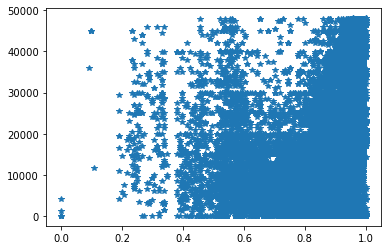

In [167]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_data[:,1], train_target, "*")

In [168]:
from sklearn.linear_model import LinearRegression
# fit a linear regressor
lin_reg = LinearRegression()
lin_reg.fit(train_data, train_target)


LinearRegression()

In [188]:
train_predict = lin_reg.predict(train_data)
train_rmse = np.sqrt(((train_target - train_predict) ** 2).mean())
print('Train RMSE =',train_rmse)


Train RMSE = 9.86354731809178e-11


In [189]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test_predict = lin_reg.predict(test_data)
test_rmse = sqrt(mean_squared_error(test_target, test_predict))
print('Test RMSE = ', test_rmse)

Test RMSE =  9.879266482053064e-11


# Feature scaling

In [181]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [182]:
lin_reg = LinearRegression()
lin_reg.fit(scaled_train_data, train_target)
train_predict = lin_reg.predict(scaled_train_data)
test_predict = lin_reg.predict(scaled_test_data)
train_rmse = np.sqrt(((train_target - train_predict) ** 2).mean())
test_rmse = sqrt(mean_squared_error(test_target, test_predict))
print('Train RMSE = ', train_rmse, ', Test RMSE =', test_rmse)

Train RMSE =  1.2352002039280583e-10 , Test RMSE = 1.2350350414855083e-10


# Regularised linear models
 Ridge Regression and Lasso Regression


In [183]:
from sklearn.linear_model import Ridge
#fit a ridge regressor
alpha_ridge = 1
ridge_reg = Ridge(alpha_ridge, solver="cholesky")
ridge_reg.fit(train_data, train_target)


Ridge(alpha=1, solver='cholesky')

In [184]:
from sklearn.linear_model import Lasso
alpha_lasso = 1
lasso_reg = Lasso(alpha_lasso)
lasso_reg.fit(train_data, train_target)


Lasso(alpha=1)

 normalise data

In [185]:
lin_reg = LinearRegression()
lin_reg.fit(train_data, train_target)
train_lin_predict = lin_reg.predict(train_data)
train_ridge_predict = ridge_reg.predict(train_data)
train_lasso_predict = lasso_reg.predict(train_data)
test_lin_predict = lin_reg.predict(test_data)
test_ridge_predict = ridge_reg.predict(test_data)
test_lasso_predict = lasso_reg.predict(test_data)
train_lin_rmse = sqrt(mean_squared_error(train_target, train_lin_predict))
train_ridge_rmse = sqrt(mean_squared_error(train_target, train_ridge_predict))
train_lasso_rmse = sqrt(mean_squared_error(train_target, train_lasso_predict))
test_lin_rmse = sqrt(mean_squared_error(test_target, test_lin_predict))
test_ridge_rmse = sqrt(mean_squared_error(test_target, test_ridge_predict))
test_lasso_rmse = sqrt(mean_squared_error(test_target, test_lasso_predict))
print('Linear Train RMSE =', train_lin_rmse, ', Linear Test RMSE =',test_lin_rmse)
print('Ridge Train RMSE =', train_ridge_rmse, ', Ridge Test RMSE =',test_ridge_rmse)
print( 'Lasso Train RMSE =', train_lasso_rmse, ', Lasso Test,RMSE =', test_lasso_rmse)

Linear Train RMSE = 9.86354731809178e-11 , Linear Test RMSE = 9.879266482053064e-11
Ridge Train RMSE = 3.090316214337595e-09 , Ridge Test RMSE = 3.0953850515094674e-09
Lasso Train RMSE = 8.754387073393957e-05 , Lasso Test,RMSE = 8.768853264972899e-05


scaled data

In [191]:
lin_reg = LinearRegression()
lin_reg.fit(scaled_train_data, train_target)
ridge_reg = Ridge(1, solver="cholesky")
ridge_reg.fit(scaled_train_data, train_target)
lasso_reg = Lasso(1)
lasso_reg.fit(scaled_train_data, train_target)
train_lin_predict = lin_reg.predict(scaled_train_data)
train_ridge_predict = ridge_reg.predict(scaled_train_data)
train_lasso_predict = lasso_reg.predict(scaled_train_data)
test_lin_predict = lin_reg.predict(scaled_test_data)
test_ridge_predict = ridge_reg.predict(scaled_test_data)
test_lasso_predict = lasso_reg.predict(scaled_test_data)
train_lin_rmse = sqrt(mean_squared_error(train_target, train_lin_predict))
train_ridge_rmse = sqrt(mean_squared_error(train_target, train_ridge_predict))
train_lasso_rmse = sqrt(mean_squared_error(train_target, train_lasso_predict))
test_lin_rmse = sqrt(mean_squared_error(test_target, test_lin_predict))
test_ridge_rmse = sqrt(mean_squared_error(test_target, test_ridge_predict))
test_lasso_rmse = sqrt(mean_squared_error(test_target, test_lasso_predict))
print('Linear Train RMSE =', train_lin_rmse, ', Linear Test RMSE =',test_lin_rmse)
print('Ridge Train RMSE =', train_ridge_rmse, ', Ridge Test RMSE =',test_ridge_rmse)
print( 'Lasso Train RMSE =', train_lasso_rmse, ', Lasso Test,RMSE =', test_lasso_rmse)

Linear Train RMSE = 1.2352002039280583e-10 , Linear Test RMSE = 1.2350350414855083e-10
Ridge Train RMSE = 0.048271355464962126 , Ridge Test RMSE = 0.048296423533675255
Lasso Train RMSE = 0.9999999999629107 , Lasso Test,RMSE = 1.0016524504924496


From above alpha = 1 -> change alpha might be more great

In [192]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]}
ridge_reg = Ridge(solver="cholesky")
grid_search = GridSearchCV(ridge_reg, param_grid)
grid_search.fit(train_data, train_target)
grid_search.best_params_

{'alpha': 0}

In [193]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]}
ridge_reg =Lasso()
grid_search = GridSearchCV(ridge_reg, param_grid)
grid_search.fit(train_data, train_target)
grid_search.best_params_

C:\Users\Kanit Jompuk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Kanit Jompuk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kanit Jompuk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Kanit Jompuk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_

{'alpha': 0}

In [194]:
from sklearn.linear_model import Ridge
#fit a ridge regressor
alpha_ridge = 0
ridge_reg = Ridge(alpha_ridge, solver="cholesky")
ridge_reg.fit(train_data, train_target)

from sklearn.linear_model import Lasso
alpha_lasso = 0
lasso_reg = Lasso(alpha_lasso)
lasso_reg.fit(train_data, train_target)

<ipython-input-194-a4834ceea515>:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_reg.fit(train_data, train_target)
C:\Users\Kanit Jompuk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0)

In [195]:
# Normal case
train_ridge_predict = ridge_reg.predict(train_data)
train_lasso_predict = lasso_reg.predict(train_data)
test_ridge_predict = ridge_reg.predict(test_data)
test_lasso_predict = lasso_reg.predict(test_data)
train_ridge_rmse = sqrt(mean_squared_error(train_target, train_ridge_predict))
train_lasso_rmse = sqrt(mean_squared_error(train_target, train_lasso_predict))
test_ridge_rmse = sqrt(mean_squared_error(test_target, test_ridge_predict))
test_lasso_rmse = sqrt(mean_squared_error(test_target, test_lasso_predict))
print('Ridge Train RMSE =', train_ridge_rmse, ', Ridge Test RMSE =',test_ridge_rmse)
print( 'Lasso Train RMSE =', train_lasso_rmse, ', Lasso Test,RMSE =', test_lasso_rmse)

Ridge Train RMSE = 4.076538851590523e-10 , Ridge Test RMSE = 4.088517830953086e-10
Lasso Train RMSE = 1.6816552611464274e-11 , Lasso Test,RMSE = 1.6844239881625044e-11


The value improved -> normal case

In [200]:
from sklearn.linear_model import Ridge
#fit a ridge regressor
alpha_ridge = 0
ridge_reg = Ridge(alpha_ridge, solver="cholesky")
ridge_reg.fit(scaled_train_data, train_target)

from sklearn.linear_model import Lasso
alpha_lasso = 0
lasso_reg = Lasso(alpha_lasso)
lasso_reg.fit(scaled_train_data,train_target)

<ipython-input-200-eeb66be121d3>:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_reg.fit(scaled_train_data,train_target)
C:\Users\Kanit Jompuk\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0)

In [201]:
# Scaled data
train_ridge_predict = ridge_reg.predict(scaled_train_data)
train_lasso_predict = lasso_reg.predict(scaled_train_data)
test_ridge_predict = ridge_reg.predict(scaled_test_data)
test_lasso_predict = lasso_reg.predict(scaled_test_data)
train_ridge_rmse = sqrt(mean_squared_error(train_target, train_ridge_predict))
train_lasso_rmse = sqrt(mean_squared_error(train_target, train_lasso_predict))
test_ridge_rmse = sqrt(mean_squared_error(test_target, test_ridge_predict))
test_lasso_rmse = sqrt(mean_squared_error(test_target, test_lasso_predict))
print('Ridge Train RMSE =', train_ridge_rmse, ', Ridge Test RMSE =',test_ridge_rmse)
print( 'Lasso Train RMSE =', train_lasso_rmse, ', Lasso Test,RMSE =', test_lasso_rmse)

Ridge Train RMSE = 1.297142526918817e-10 , Ridge Test RMSE = 1.3005853663718624e-10
Lasso Train RMSE = 3.973538485007878e-11 , Lasso Test,RMSE = 3.976180310306684e-11


The value improved -> scaled case